In [1]:
# import the required libraries
import os
import ctools
import random

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm, LogNorm
from astropy import units as u

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# for modify xml file of model.xml
from lxml import etree
import pandas as pd
from tqdm import tqdm

__Image Processing and Computer Vision: CTA projetc__

Falco Riccardo - riccardo.falco2@tudio.unibo.it - 991986

## **Parameters**

### **Common parameters**

* `pointing`$\Rightarrow$ are the sky coordinates where the telescope is pointing. 
* `fov` $\Rightarrow$ **Field of View** (FoV): This refers to the area of sky visible to a particular telescope. For example, CTA’s Small-Sized Telescopes will have a field of view of around 9 degrees, meaning they will observe a circular area of sky with a diameter of 9 degrees.
* `roi` $\Rightarrow$ **Region of Interest** (RoI): In astronomy, this is a region of the sky or in an image on which the scientist wants to focus because of its physics importance.


In [3]:
pointing = np.array([83.6331, 22.5145])
fov = 5 
roi = 5
time = (0, 100)

In [4]:
no_crab_skymap = os.path.join('data', 'dataset', 'no_crab_sky.fits')

### **Group 2 parameters**

* `energy` $\Rightarrow$ **Energy**: Property that all objects in the Universe have, and it can be understood as the capability to perform an activity. 
* `irf` $\Rightarrow$ **Instrument Response Function** (IRF): Group of characteristics that define the behavior of an instrument, such a Cherenkov telescope, and which must be considered during data analysis (one of them is, for example, the collection area of the instrument).


In [6]:
energy=(0.1, 50)
irf = 'South_z20_0.5h'

## **Define folders**

In [7]:
# base folder of the datas
base_folder = './data/dataset'
if not os.path.isdir(base_folder):
    os.mkdir(base_folder)

# folder of observations
obs_folder = './data/dataset/observetions'
if not os.path.isdir(obs_folder):
    os.mkdir(obs_folder)

# folder of skymaps
skymaps_folder = './data/dataset/skymaps'
if not os.path.isdir(skymaps_folder):
    os.mkdir(skymaps_folder)
    
# base folder of the datas
tmp_folder = './data/dataset/temp'
if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)

## **Create dataset**

* Here we construct the dataset, that it will be composed by 1000 images with not more than 3 soures for each observation image.

In [8]:
n = 1000
max_deg = 3
p_no_crab = 0.5
p_1_crab = 0.3
p_2_crab = 0.15
p_3_crab = 0.05

More precisely we will have:
* 500 images background only
* 300 with 1 sources
* 150 with 2 sources in the same image
*  50 with 3 sources

In [9]:
n_0 = np.ceil(n * p_no_crab)
n_1 = np.ceil(n * p_1_crab)
n_2 = np.ceil(n * p_2_crab)
n_3 = n - (n_0 + n_1 + n_2)
n_0, n_1, n_2, n_3

(500.0, 300.0, 150.0, 50.0)

In [10]:
X = []
y = []
num_sorces = []
file_names = []
offset = []
i = 0
while i < n:
    eps = random.randint(0, 3)
    if eps == 0 and n_0 > 0:
        i += 1
        n_0 -= 1
        X.append([0, 0])
        y.append('no')
        num_sorces.append(0)
        file_names.append('crab_sky'+ "%03d" %(i,) +'.fits')
    elif eps == 1 and n_1 > 0:
        i += 1
        n_1 -= 1
        X.append([np.random.uniform(pointing[0]-max_deg, pointing[0]+max_deg),
                  np.random.uniform(pointing[1]-max_deg, pointing[1]+max_deg)])
        y.append('yes')
        num_sorces.append(1)
        file_names.append('crab_sky'+ "%03d" %(i,) +'.fits')
    elif eps == 2 and n_2 > 0:
        i += 1
        n_2 -= 1
        for j in range(2):
            X.append([np.random.uniform(pointing[0]-max_deg, pointing[0]+max_deg),
                      np.random.uniform(pointing[1]-max_deg, pointing[1]+max_deg)])
            y.append('yes')
            num_sorces.append(2)
            file_names.append('crab_sky'+ "%03d" %(i,) +'.fits')
    elif eps == 3 and n_3 > 0:
        i += 1
        n_3 -= 1
        for j in range(3):
            X.append([np.random.uniform(pointing[0]-max_deg, pointing[0]+max_deg),
                      np.random.uniform(pointing[1]-max_deg, pointing[1]+max_deg)])
            y.append('yes')
            num_sorces.append(3)
            file_names.append('crab_sky'+ "%03d" %(i,) +'.fits')

Here instead there is the `.csv` which represents the dataset with list of observed event containg background only or background + a source. Each row of the dataset indeed comprends:
* `File_name` the name of the FITS file,
* `Source-ra` and `Source-dec` represent the _right ascension_ and the _declination_ coordinates in the Equatorial Coordinate System of the corrispondig gamma flare's source,
* `N_sources` which indicates how many sources there are in the same FITS file,
* `Label` meaning if the image is background + source or not, i.e. `Label = yes` $\Leftrightarrow$ `N_sources > 0`, `Label = no` other.

In [11]:
df = pd.DataFrame({'File_name':file_names,
                   'Source-ra':np.array(X)[:,0],
                   'Source-dec':np.array(X)[:,1],
                   'N_sources':num_sorces,
                   'Label': y})
df

,File_name,Source-ra,Source-dec,N_sources,Label
0,crab_sky001.fits,83.594197,21.410309,1,yes
1,crab_sky002.fits,81.112909,21.824453,1,yes
2,crab_sky003.fits,0.000000,0.000000,0,no
3,crab_sky004.fits,85.779273,23.729835,3,yes
4,crab_sky004.fits,82.622388,23.012836,3,yes
...,...,...,...,...,...
1245,crab_sky996.fits,0.000000,0.000000,0,no
1246,crab_sky997.fits,0.000000,0.000000,0,no
1247,crab_sky998.fits,0.000000,0.000000,0,no
1248,crab_sky999.fits,0.000000,0.000000,0,no


Finally this will be the distribution of the dataset, as we would like to have.

<AxesSubplot:title={'center':'Labels histogram'}, xlabel='Label'>

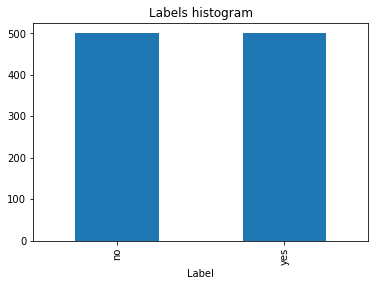

In [12]:
plt.title('Labels histogram')
df.groupby(['File_name', 'Label'], as_index=False).count() \
  .groupby('Label')['Label'].count().plot.bar()

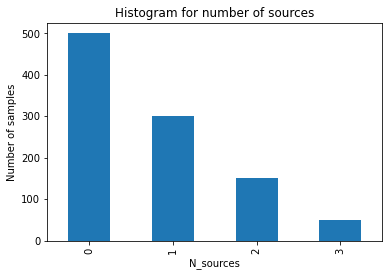

In [13]:
plt.title('Histogram for number of sources')
plt.ylabel('Number of samples')
df.groupby(['File_name', 'N_sources'], as_index=False).count() \
  .groupby('N_sources')['N_sources'].count()                   \
  .plot.bar()
plt.show()

## **Functions**

### ctobssim

`ctobssim` simulates event list(s) using the instrument characteristics specified by the instrument response function(s) and an input model. The simulation includes photon events from astrophysical sources and background events from an instrumental background model (`irf`).

In [14]:
def run_ctobssim(model, pointing, output, energy=(0.03, 150), time=(0, 1200), fov=5, 
                 caldb='prod3b-v2', irf='South_z40_0.5h', seed=1):
    sim = ctools.ctobssim()
    sim["inmodel"] = model
    sim["outevents"] = output
    sim["caldb"] = caldb
    sim["irf"] = irf
    sim["ra"] = pointing[0]
    sim["dec"] = pointing[1]
    sim["rad"] = fov
    sim["tmin"] = time[0]
    sim["tmax"] = time[1]
    sim["emin"] = energy[0]
    sim["emax"] = energy[1]
    sim["seed"] = seed
    sim.execute()

### skymap

`ctskymap` creates a sky map from either a single event list or event lists provided in an observation definition file. The tool will loop over all event lists that are provided and fill all events into a single sky map. Only events within an energy interval spanned by emin and emax are considered.

In [15]:
def run_skymap(obs, output, energy=(0.03, 150), roi=5, caldb='prod3b-v2', 
               irf='South_z40_0.5h', wbin=0.02):
    nbin = int(roi*2/wbin)
    skymap = ctools.ctskymap()
    skymap['inobs'] = obs
    skymap['outmap'] = output
    skymap['irf'] = irf
    skymap['caldb'] = caldb
    skymap['emin'] = energy[0]
    skymap['emax'] = energy[1]
    skymap['usepnt'] = True
    skymap['nxpix'] = nbin
    skymap['nypix'] = nbin
    skymap['binsz'] = wbin
    skymap['bkgsubtract'] = 'IRF'
    skymap.execute()

### generateSourceModel

* To build a good synthetic observation, it is necessary to build a model `XML` which defines all the properties that the we would like to have in our observation.

* Here it is possible to see an example of this XML model

Two relevant parts:
* `PointSource` which refear to the parameters important to model the source of the current observation. Notice the `parameter`s of `PointSource` child contain the indeed the position (i.e. in Equatorial Coordinates System) of our observation

* `CTAIrfBackground` corresponds instead to the function used by the tool to model the background of the instrument used for performing the observations

`generateSourceModel` is the function that perfoms updates to the XML file in order to symulate the observations.

In [16]:
def generateSourceModel(source, n_sources):
    if n_sources == 0:
        model = './models/no_crab.xml'
        return model
    elif n_sources == 1:
        model = './models/crab1.xml'
    elif n_sources == 2:
        model = './models/crab2.xml'
    elif n_sources == 3:
        model = './models/crab3.xml'
    tree = etree.parse(model)
    root = tree.getroot()
    # change value of spatialmodel source:
    for i in range(len(source)):
        spatialmodel = root[i][1]
        # ra value
        spatialmodel[0].set('value', str(source[i,0]))
        # dec value
        spatialmodel[1].set('value', str(source[i,1]))
    # Rewrite new values on the xml file
    tree.write(model, pretty_print=True)
    return model

### createSource

Finally with this function it is possible to performs all the previous steps in function of all the parameters presented before.

In [17]:
def createSource(filename,
                 model,
                 pointing=(83.6331, 22.5145),
                 energy=(0.03, 150),
                 fov=5,
                 roi=5,
                 irf='South_z20_0.5h',
                 time=(0, 1200),
                 data_folder='./data/dataset', 
                 data_folder_sim=None, 
                 data_folder_skymap=None,
                 seed=1,
                 print_name_file=False):

    # create the simulation
    if not data_folder_sim == None:
        folder = data_folder_sim
    else:
        folder = data_folder
        
    # I can create the observetion
    obs=folder+'/'+filename
    run_ctobssim(model=model, pointing=pointing, energy=energy, 
                 time=time, fov=fov, irf=irf, output=obs, seed=seed)
    if print_name_file:
        print(model)
        print(obs)
    # ... and create skymap
    if not data_folder_skymap == None:
        folder = data_folder_skymap
    else:
        folder = data_folder
    skymap=folder+'/'+filename
    if print_name_file:
        print(skymap)
    run_skymap(obs=obs, output=skymap, energy=energy, irf=irf)
    

### genSimulations

The following function manage to iterate over all the dataset and for each row, it performs a `createSource`.

In [18]:
def genSimulations(df, 
                   pointing=(83.6331, 22.5145),
                   energy=(0.03, 150),
                   fov=5,
                   roi=5,
                   irf='South_z20_0.5h',
                   time=(0, 1200),
                   data_folder='./data/dataset', 
                   model='./models/crab1.xml', 
                   data_folder_sim=None,
                   data_folder_skymap=None,
                   seed = 1,
                   skymap_seed_ub=2048): # upperbound skymap random seed
    
    filename = ''
    k = 0
#     np.random.seed(seed=1)
    np.random.seed(seed=seed)
    for i in tqdm(range(len(df))):
        if filename == df.iloc[i]['File_name']:
            continue
        filename = df.iloc[i]['File_name']
        
        num_sources = df.iloc[i]['N_sources']
        if num_sources == 0: 
            X = np.array([0, 0])
        else:
            X = []
            for j in range(i, i+num_sources):
                X.append([df.iloc[j]['Source-ra'],
                          df.iloc[j]['Source-dec']])
            X = np.array(X)
        # overwrite the previous model with the new source
        model = generateSourceModel(X, num_sources)
        
        # create the seed of the skymap
        skymap_seed = np.random.randint(skymap_seed_ub)
        
        if (not data_folder_sim==None) and (not data_folder_skymap==None):
            createSource(filename, model, energy=energy, time=time, 
                         fov=fov, roi=roi, irf=irf, 
                         data_folder_sim=data_folder_sim, 
                         data_folder_skymap=data_folder_skymap,
                         seed=skymap_seed)
        else:
            createSource(filename, model, energy=energy, time=time, fov=fov, 
                         roi=roi, irf=irf, data_folder=data_folder,
                         seed=skymap_seed)
        k += 1

In [19]:
genSimulations(df,
               data_folder_sim=obs_folder, 
               data_folder_skymap=skymaps_folder)

100%|██████████| 1250/1250 [5:37:58<00:00, 16.22s/it]  


## **Save .csv**

Finally let's save the dataframe

In [20]:
df.to_csv(base_folder+'/skymap_set.csv', index=False)

In [21]:
df

,File_name,Source-ra,Source-dec,N_sources,Label
0,crab_sky001.fits,83.594197,21.410309,1,yes
1,crab_sky002.fits,81.112909,21.824453,1,yes
2,crab_sky003.fits,0.000000,0.000000,0,no
3,crab_sky004.fits,85.779273,23.729835,3,yes
4,crab_sky004.fits,82.622388,23.012836,3,yes
...,...,...,...,...,...
1245,crab_sky996.fits,0.000000,0.000000,0,no
1246,crab_sky997.fits,0.000000,0.000000,0,no
1247,crab_sky998.fits,0.000000,0.000000,0,no
1248,crab_sky999.fits,0.000000,0.000000,0,no
